# Dynamic Time Warping for Speech Recognition
Chloé Clavel / Matthieu Labeau (original lab by Olivier Cappé)

In [ ]:
import os
import scipy
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Data

The directory ```DATA``` contains three directories :
- ```SIG``` contains 12 repetitions of numbers from 0 to 9 by speaker1 (F e = 8000kHz). SIG_Rep_5_Number_3.wav is the recording corresponding to the fifth repetition of the number “3” . The first four repetitions of each number are represented on Figure 1.
- ```SIG2```, contains 6 repetitions of numbers from 0 to 9 by speaker2
- ```SIG_MIXED``` contains 6 repetitions of the number by speaker1 (SIG_MIXED_Rep_1:6) and then by speaker2 ( SIG_MIXED_Rep_7:12).

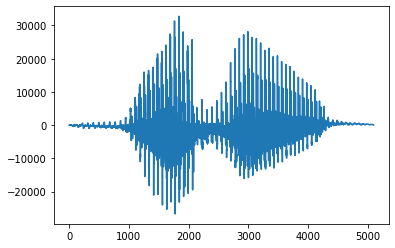

In [ ]:
from scipy.io import wavfile

file_path = "Data/SIG/SIG_Rep_1_Number_0.wav"
sample_rate, wav_data = wavfile.read(file_path)
plt.plot(wav_data)
plt.show()

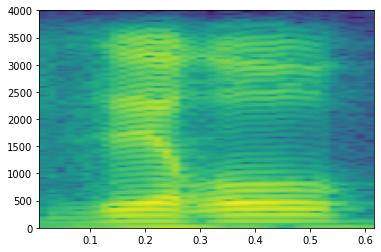

In [ ]:
plt.specgram(wav_data, Fs=sample_rate)
plt.show()

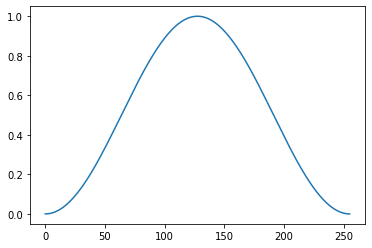

In [ ]:
plt.plot(np.hanning(256))

## Speech Feature Extraction

Write a python function ```feature_extraction``` to calculate the cepstral parameterization associated with each pronunciation. With regard to the parameters of the analysis, we will make the following choices: 
- **Parameterization type**: Cepstrum (real number) using linear frequency scale (as opposed to Mel-frequency cepstrum) and computed using FFT (Fast Fourier Transform)
- **Weigthing window**: Hanning

The inputs of the function will be the following:
- **Wav data**: The data extracted from a .wav file
- **Window size**: 256 samples (32 ms)
- **Window shift**: 128 samples
- **Cepstral order**: p = 10


For each signal, the result of the analysis is a sequence of parameters that will be stored in a matrix
according to the following convention:

$$ \quad X = \underbrace{\left[\begin{array}{c} 
 X_1 \\
 X_2 \\
 \vdots \\
 X_{l_X}
\end{array} \right]}_p  $$

Each $X_i$ is a line vector of size $p$. Note that the number of ceptral vectors obtained ($l_X$) depends on the length of the signal, so it is variable. We obtain one matrix of this type per signal.

In [ ]:
def feature_extraction(wav_data, window_size, window_shift, cepstral_order):
    #
    # Indication: use the numpy functions np.hanning, np.fft.fft, and np.fft.ifft.
    # Use the attribute .real to take the real part of complex numbers that are output by np.fft.ifft
    # Don't hesitate to look at the numpy documentation to get a better understanding of what the functions do !
    hamming = np.hamming(window_size)
    idx_left = 0
    idx_right = window_size

    windows = []
    while idx_right <= len(wav_data):
        windows.append(wav_data[idx_left: idx_right] * hamming)
        idx_left += window_shift
        idx_right += window_shift

    FFT = np.array([np.fft.fft(window) for window in windows])
    LogFFT = np.log(np.abs(FFT))
    cepstral_vectors = np.array([np.fft.ifft(f).real for f in LogFFT])[:, :cepstral_order]
    
    return cepstral_vectors

In [ ]:
# Example !
window_size = 256
window_shift = 128
cepstral_order = 10
cepstral_vectors = feature_extraction(wav_data, window_size, window_shift, cepstral_order)

In [ ]:
print("Shape of cepstral matrix:", [len(cepstral_vectors), len(cepstral_vectors[0])])

Shape of cepstral matrix: [38, 10]


## Time Alignment by Dynamic Programming

Write a python function ```time_alignment(x, y, gamma)``` performing time alignment by dynamic programming between two sequences of vectors stored with the convention above. The Euclidean norm between the following vectors and time
constraints will be used:

\begin{matrix}
  \bullet & \rightarrow & \bullet\\
   & \nearrow_{\gamma} & \uparrow\\
  \bullet & & \bullet
\end{matrix}

with a diagonal weighting $\gamma$ that may be chosen different from 1. It is essential to carry out this function in a parameterized way in order to be able to validate it on the mono-dimensional example being studied.
The function will take as **inputs** the two vector sequences $(X_1, \dots, X_{l_X})$ et $(Y_1, \dots, Y_{l_Y})$ stored in the two matrices, as well as the parameter $\gamma$. It will then execute the following operations:
- **Calculation of the similarity matrix**: Given the two vector sequences, calculate the matrix $D (l_X \times l_Y)$ such that $D(i,j) = \|X_i-Y_j\|$.
- **Initialization of the cumulative distance matrix**: Calculate the content of the first row and column of the cumulative distance matrix $C (l_X \times l_Y)$ such that $C(i,j)$ contains the cumulative distance along the minimum cumulative distance path joining the node $(i,j)$ at the initial node $(1,1)$.
- **Calculation of the matrix of cumulative distances**: For $i$ ranging from 2 to $\min(l_X,l_Y)$, calculation of $C(i,i)$ then $C(i+1,i), \dots C(l_X,i)$ and $C(i,i+1), C(i,i+2), \dots C(i,l_Y)$ (you will recall what justifies this way to proceed). To store the predecessor along the optimal path leading to $(i,j)$, you can use a three-dimensional array $B (l_X \times l_Y \times 2)$ since the predecessor is a node of the network defined by its two coordinates (we can alternatively use a "code" representing the three possible predecessors).
- ***Bactracking***: From the node $(l_X,l_Y)$, reconstruction of the optimal path (starting from the end).

Finally, the **output** will be the cumulative distance along the path of least cost  (```distance```) and the alignment path (```M```), in the form of the matrix  $M$  with two columns such that $X_{M(i,1)}$  is the vector mapped to $Y_{M(i,2)}$ (note that the number of lines in this matrix corresponding to the length of the optimal path is variable). The function can also return the matrix of cumulative distances (```C```).

In [ ]:
# Implementing a function that BackTracks the warp path from a calculated Cumulated Distance Matrix
def find_wp(cum_dist_matrix):
    path = []
    current = (cum_dist_matrix.shape[0]-1,cum_dist_matrix.shape[1]-1)
    path.append(current)
    while True : 
        i,j = current     
        a = np.min([cum_dist_matrix[i-1,j], cum_dist_matrix[i,j-1], cum_dist_matrix[i-1,j-1]])
        x,y = np.where(cum_dist_matrix == a)
        current = (x[0],y[0])
        path.append(current)
        if x[0] == 0 and y[0] == 0 :
            break
    path = np.array(path[::-1])
    return path

In [ ]:
from scipy.spatial.distance import cdist
# Implementation adapted from the librosa library

def time_alignment(x, y, gamma):
    distance_matrix = cdist(x,y, metric = 'euclidean')
    cumulative_distance = np.zeros_like(distance_matrix)
    cumulative_distance[0,:] = distance_matrix[0,:].cumsum()
    cumulative_distance[:,0] = distance_matrix[:,0].cumsum()
    denom = 0
    for i in range(1,cumulative_distance.shape[0]):
        for j in range(1,cumulative_distance.shape[1]) :
            cumulative_distance[i,j] = distance_matrix[i,j] + np.min([cumulative_distance[i-1,j], cumulative_distance[i,j-1], cumulative_distance[i-1,j-1]*gamma])
    
    C = cumulative_distance      
    M = find_wp(C)

    # Scaling the path by orientation weights (+1 if horizontal or vertical // +gamma if diagonal) 
    denom = 0
    for i in range(len(M)-1) : 
        if M[i][0] == M[i+1][0] or M[i][1] == M[i+1][1]:
            denom += 1
        else :
            denom += 2
    distance = C[-1,-1] / denom
    
    return C, M, distance

In [ ]:
# Example of time alignment
file_path_1 = "Data/SIG/SIG_Rep_1_Number_5.wav"
sample_rate_1, wav_data_1 = wavfile.read(file_path_1)
file_path_2 = "Data/SIG/SIG_Rep_10_Number_7.wav"
sample_rate_2, wav_data_2 = wavfile.read(file_path_2)

cepstral_vectors_1 = feature_extraction(wav_data_1, window_size, window_shift, cepstral_order)
cepstral_vectors_2 = feature_extraction(wav_data_2, window_size, window_shift, cepstral_order)

np.set_printoptions(precision=2)
#C, M, distance = time_alignment_alb(cepstral_vectors_1, cepstral_vectors_2, gamma=1.4)
C, M, distance = time_alignment(cepstral_vectors_1, cepstral_vectors_2, gamma=2)

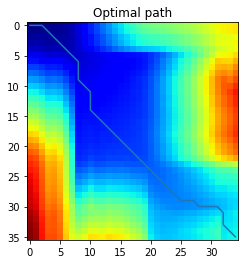

Cost of the optimal path: 0.5748263264047958


In [ ]:
# Example of visualization of the optimal path
wp = np.array(M)
plt.imshow(C, cmap='jet')
plt.title("Optimal path")
plt.plot(wp[:,1],wp[:,0])
plt.show()
print("Cost of the optimal path:", distance)

Cost of the optimal path: 0.5748263264047958


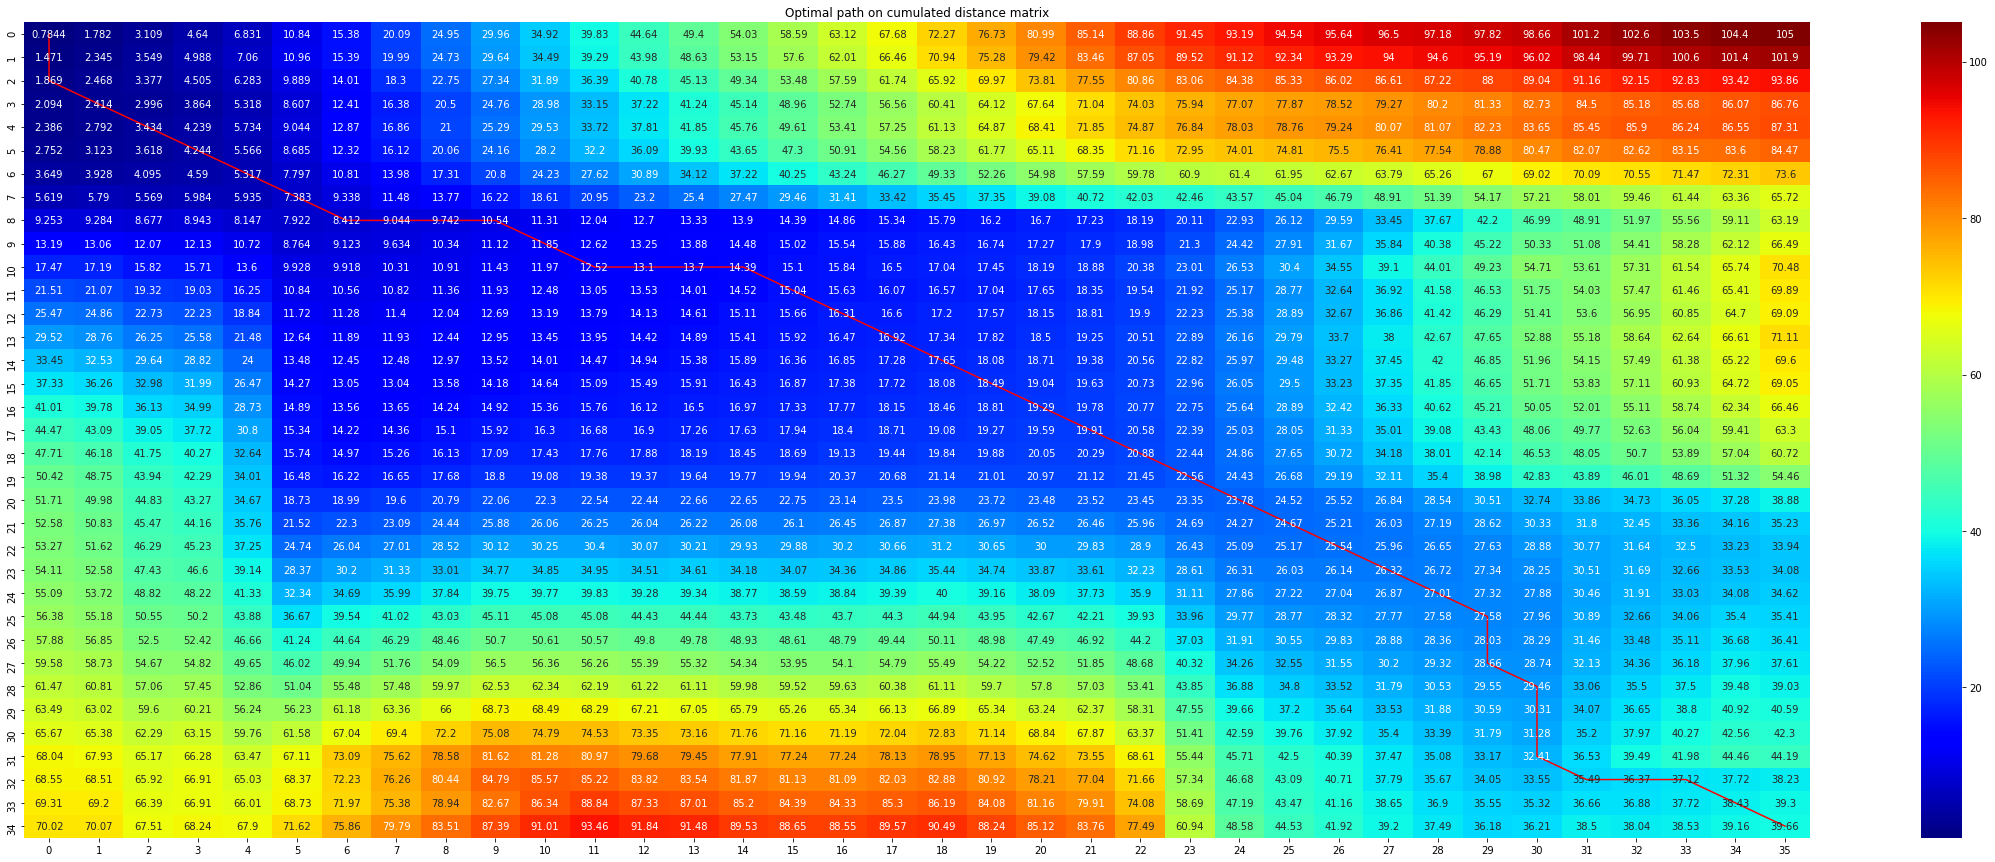

In [ ]:
# Replotting on a bigger figure, with annotations

plt.figure(figsize=(40,15))
sns.heatmap(C.T, annot=True, cmap='jet', fmt='.4g')
plt.plot(wp[:,0]+0.5,wp[:,1]+0.5, c='red')
plt.title("Optimal path on cumulated distance matrix");
print("Cost of the optimal path:", distance)

## Applications to Speech Data

First, working on the data from ```SIG```, you will align a reference sequence (for example, the one corresponding to the first repetition of the first word) with all the others. If we try to find, among all numbers of a given repetition (from 1 to 12), which is the same one as the reference, by looking at the closest in terms of distance (of the path of least cost):
1. Are the performances satisfactory ?
2. What is the influence of the γ choice (weighting of the diagonal path) on the alignment paths (in order to answer, examine characteristic cases and try to judge the relevance of the alignment paths by visualizing them) ? Does this parameter have a significant influence on the obtained distance?
3. What implicit hypothesis is made when using the Euclidean distance to measure the proximity of ceptral vectors? Does this hypothesis seem acceptable to you in view of the differences between aligned sequences corresponding to different repetitions of the same word? Propose (it is not necessary to implement it!) a method to estimate from the aligned data an appropriate weighting for the comparison of ceptral vectors. Do you think this weighting could improve discrimination performance?

In [ ]:
print("Overall score for similariy across repetitions: {} %".format(np.round(np.mean(scores),5)*100))

Overall score for similariy across repetitions: 97.361 %


1.  With an overall score of ~97%, we consider that the performances are very satisfactory 

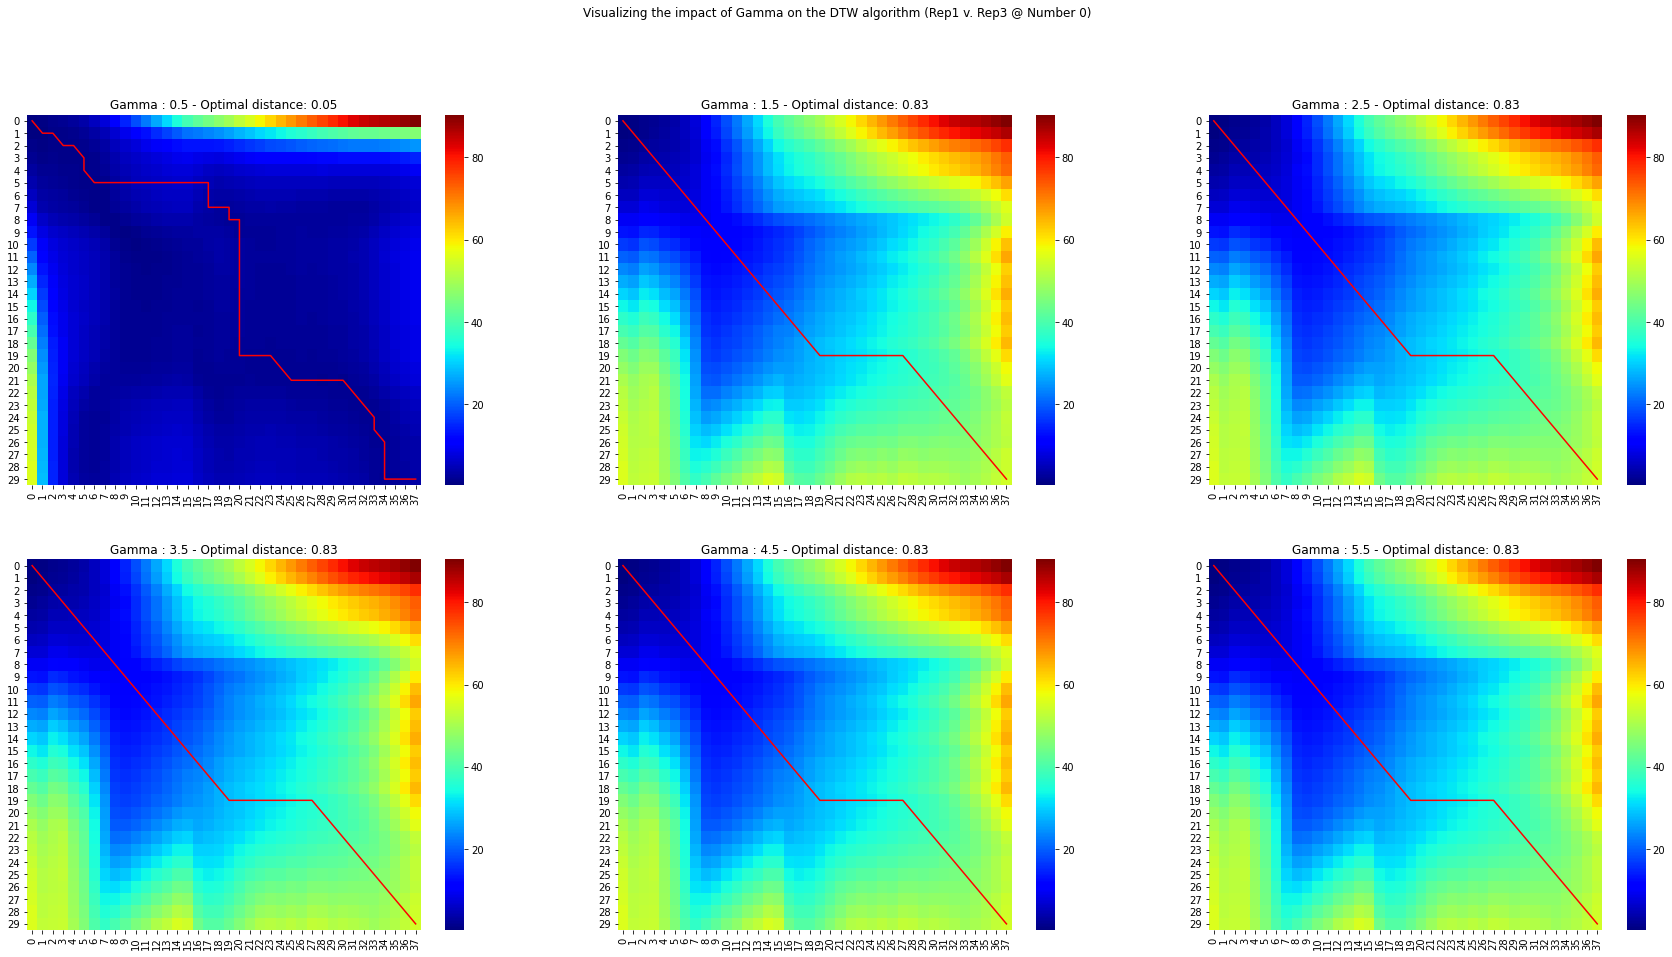

In [ ]:
## Visualizting the shortest paths and the influence of the Gamma parameter:

gammas = np.arange(.5,6.5)
i=0

# Example of time alignment
file_path_1 = "Data/SIG/SIG_Rep_1_Number_0.wav"
sample_rate_1, wav_data_1 = wavfile.read(file_path_1)
file_path_2 = "Data/SIG/SIG_Rep_6_Number_6.wav"
sample_rate_2, wav_data_2 = wavfile.read(file_path_2)

cepstral_vectors_1 = feature_extraction(wav_data_1, window_size, window_shift, cepstral_order)
cepstral_vectors_2 = feature_extraction(wav_data_2, window_size, window_shift, cepstral_order)

np.set_printoptions(precision=2)
plt.subplots(2,3, figsize=(30,15))


def draw(gamma = 1):
    C1, wp1, distance1 = time_alignment(cepstral_vectors_1, cepstral_vectors_2, gamma=gamma)
    sns.heatmap(C1.T, annot=False, cmap='jet', fmt='.4g')
    plt.plot(wp1[:,0]+0.5,wp1[:,1]+0.5, c='red')
    plt.title("Gamma : {} - Optimal distance: {}".format(gamma, np.round(distance1,2)));

plt.suptitle('Visualizing the impact of Gamma on the DTW algorithm (Rep1 v. Rep3 @ Number 0)')
plt.subplot(231)
draw(gammas[i])
i+=1

plt.subplot(232)
draw(gammas[i])
i+=1

plt.subplot(233)
draw(gammas[i])
i+=1

plt.subplot(234)
draw(gammas[i])
i+=1

plt.subplot(235)
draw(gammas[i])
i+=1

plt.subplot(236)
draw(gammas[i])
i+=1



2. As we can see in the graphs above, the higher the Ɣ value gets, the less "breaky" the optimal paths gets (which means that it tends to favor a straight diagonal line with not that many changes of direction).
   We can also see that as the Ɣ value gets, the higher the cost of the optimal path gets, and converges to a maximum path, a value it doesn't not go over.

## Evaluation of Speech Recognition

The goal of this part is to implement different cross-validation strategies in order to evaluate how well our method can be used for speech recognition, especially when we generalize to more than one speaker. 
We will separate the available signals into a *training* and *testing* set, and label all the test signals by finding the signal in the training set they are the closest to (in terms of cost of the optimal path given by ```time_alignement```. We will then rotate the training/testing sets to perform cross-validation. 
To do so, write a function ```evaluation_recognition```. For example, you can use the following formalism : 

```[confusion, accuracy, D] = evaluation_recognition(vectors, gamma, protocol)```

- ```vectors``` contains all the cepstral vectors for the signals in the database. It can be under the form of a list of matrices, being the outputs of ```feature_extraction``` for all signals. If $N$ if the number of repetetitions, ```vectors``` contains $10N$ matrices.
- ```gamma``` is the parameter $\gamma$ of the alignment.
- ```protocol``` is an integer value between 1 and 3 indicating the protocol to be used: each protocol corresponds to a particular way of dividing signals into training and testing sets. 


- ```confusion``` is the confusion matrix of size $10 \times 10$.
- ```accuracy``` is the recognition rate.
- ```D``` is the distance matrix between each of the elements of the database of size $10N \times 10N$, where $N$ is the number of repetitions. Note that only parts of ```D``` will be used, depending on the protocol choosed. 

The three proposed evaluation protocols are:
- **Protocol 1**: The database is randomly divided in three subsets. Two of these subsets (2/3 of repetitions) are used for the training set and the remaining subset (1/3 of repetitions) is used for the test set. The procedure is repeated by rotating the test and training sets.
- **Protocol 2**: A database containing only one pronunciation of each number is used as a training database. The remaining repetitions are used for the test set. The procedure is repeated by rotating the test and training sets. This protocol aims at evaluating the generalization capabilities of the recognition system. 
- **Protocol 3**: The first half of the database of ```SIG_MIXED``` is used as a training database and the second half as the test database. The procedure is repeated by inversing the role of the two sets. This protocol aims at evaluating the generalization capabilities on a database containing data from the two speakers. Careful: since the goal here is to understand if you can use examples from one person to recognize numbers pronounced by a different person, you have to not shuffle the examples !

Questions: 
- Evaluate the speech recognition performance with protocol 1 on the data ```SIG```, and then on the data ```SIG2```. What are the confusions ? What value of $\gamma$ parameter offers the best results ?
- Evaluate the generalization capabilities using protocol 2 on the data ```SIG```, and then on the data ```SIG2```. What do you notice?
- Evaluate the generalization capabilities to other speakers using protocol 3 on ```SIG_MIXED```. Explain the results.
- What are the limitations of dynamic time warping approaches for speech recognition that you have identified during this lab ? Propose possible solutions to these problems.

## Evaluation du Dataset SIG

In [130]:
def compare_sig(repetition_1, repetition_2, gamma=2):
    
    """ A function that takes two repetitions and compares them.
    Every number in repetition_1 is compared to all numbers in repetition_2, and the match with the lowest distance is retained.
    If the retained number matches the reference number, it is a match.
    The function returns a score of how many matches between repetitions.
    """
    path = "Data/SIG/SIG_Rep_{}_Number_{}.wav"
    score = 0
    for i in range(10):
        distances_repetition= []
        # Reference sequence : 
        reference_path = path.format(repetition_1,i)
        sample_rate_ref, wav_data_ref= wavfile.read(reference_path)
        cepstral_vectors_ref = feature_extraction(wav_data_ref, window_size, window_shift, cepstral_order)
        
        for j in range(10):
            # Tested sequence : 
            tested_path = path.format(repetition_2,j)
            sample_rate_ref, wav_data_ref= wavfile.read(tested_path)
            cepstral_vectors_tested = feature_extraction(wav_data_ref, window_size, window_shift, cepstral_order)

            C, wp, distance = time_alignment(cepstral_vectors_ref, cepstral_vectors_tested, gamma=gamma)
            distances_repetition.append(distance)
            
        min_idx = np.argmin(distances_repetition)
        if min_idx == i : 
            score += 1
        #print("Closest to Number {} is Number {} ".format(i,min_idx))
    score = score / 10
    return score

In [131]:
scores_sig = np.zeros([12,12])
for i in range(scores_sig.shape[0]):
    for j in range(scores_sig.shape[1]):
        scores_sig[i,j] = compare_sig(repetition_1 = i+1,repetition_2 = j+1, gamma = 1.5)

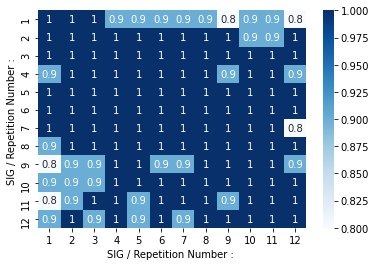

In [141]:
fig, ax = plt.subplots()

sns.heatmap(scores_sig, annot=True, cmap='Blues')
plt.xlabel("SIG / Repetition Number : ")
plt.ylabel("SIG / Repetition Number : ")

labels_x= list(np.arange(1,13))
labels_y= list(np.arange(1,13))

ax.set_xticklabels(labels_x);
ax.set_yticklabels(labels_y);

In [136]:
print("Overall score for similariy SIG-SIG: {} %".format(np.round(np.mean(scores_sig),5)*100))

Overall score for similariy SIG-SIG: 97.361 %


## Evaluation du Dataset SIG2

In [ ]:
def compare_sig2(repetition_1, repetition_2, gamma=2):
    
    """ A function that takes two repetitions and compares them.
    Every number in repetition_1 is compared to all numbers in repetition_2, and the match with the lowest distance is retained.
    If the retained number matches the reference number, it is a match.
    The function returns a score of how many matches between repetitions.
    """
    path = "Data/SIG/SIG_Rep_{}_Number_{}.wav"
    path2 = "Data/SIG2/SIG2_Rep_{}_Number_{}.wav"

    score = 0
    for i in range(10):
        distances_repetition= []
        # Reference sequence : 
        reference_path = path.format(repetition_1,i)
        sample_rate_ref, wav_data_ref= wavfile.read(reference_path)
        cepstral_vectors_ref = feature_extraction(wav_data_ref, window_size, window_shift, cepstral_order)
        
        for j in range(10):
            # Tested sequence : 
            tested_path = path2.format(repetition_2,j)
            sample_rate_ref, wav_data_ref= wavfile.read(tested_path)
            cepstral_vectors_tested = feature_extraction(wav_data_ref, window_size, window_shift, cepstral_order)

            C, wp, distance = time_alignment(cepstral_vectors_ref, cepstral_vectors_tested, gamma=gamma)
            distances_repetition.append(distance)
            
        min_idx = np.argmin(distances_repetition)
        if min_idx == i : 
            score += 1
        #print("Closest to Number {} is Number {} ".format(i,min_idx))
    score = score / 10
    return score

In [137]:
scores_sig2 = np.zeros([12,6])
for i in range(scores_sig2.shape[0]):
    for j in range(scores_sig2.shape[1]):
        scores_sig2[i,j] = compare_sig2(repetition_1 = i+1,repetition_2 = j+1, gamma = 1.5)

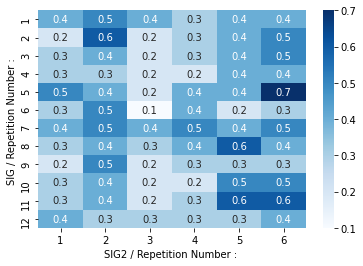

In [140]:
fig, ax = plt.subplots()

sns.heatmap(scores_sig2, annot=True, cmap='Blues')
plt.xlabel("SIG2 / Repetition Number : ")
plt.ylabel("SIG / Repetition Number : ")

labels_x= list(np.arange(1,7))
labels_y= list(np.arange(1,13))

ax.set_xticklabels(labels_x);
ax.set_yticklabels(labels_y);

In [139]:
print("Overall score for similariy SIG v. SIG2: {} %".format(np.round(np.mean(scores_sig2),5)*100))

Overall score for similariy SIG v. SIG2: 36.528 %
